<a href="https://colab.research.google.com/github/clovisdanielss/Colab-Projects/blob/main/food101/Food_101_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Summary

1. We'll first load our dataset and apply data-augumentation to it. Data augumentation will prevent overfitting later. 

2. Later we'll define a very simple model, which will be our baseline model. 

3. At last we'll use transfer learning to check the difference between the performances. 

4. We'll also try to improve our results using **fine-tunning transfer learning**, which consists of unfreeze some of the top layers of the **feature extraction** model.

### Loading dataset

In [1]:
!pip install tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import tensorflow_datasets as tfds
import tensorflow
import tensorflow_hub as tfhub
from tensorflow.keras.applications import efficientnet_v2, resnet_v2
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator, smart_resize
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf

In [5]:
data = tfds.load("food101", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteQY2QI3/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteQY2QI3/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [6]:
data, info = data

In [7]:
labels = []
with open("/root/tensorflow_datasets/food101/2.0.0/label.labels.txt", "r") as file:
  labels = [line.rstrip() for line in file]

labels[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
list(data["train"].take(1).as_numpy_iterator())[0]["label"]

56

In [ ]:
image = list(data["train"].take(1).as_numpy_iterator())[0]["image"]
image_resized = smart_resize(image, (128,128))
image.shape, image_resized.shape

((512, 512, 3), (128, 128, 3))

In [ ]:
generator_factory = ImageDataGenerator(rescale=1/255)
iterator = data['train'].take(10000)
datagen_train = generator_factory.flow(np.array([smart_resize(ele['image'], (128,128)) for ele in iterator.as_numpy_iterator()]),
                                       y=[ele['label'] for ele in iterator.as_numpy_iterator()],
                                       batch_size=32)
iterator = data['validation'].take(5000)
datagen_test = generator_factory.flow(np.array([smart_resize(ele['image'], (128,128)) for ele in iterator.as_numpy_iterator()]),
                                       y=[ele['label'] for ele in iterator.as_numpy_iterator()],
                                       batch_size=32)

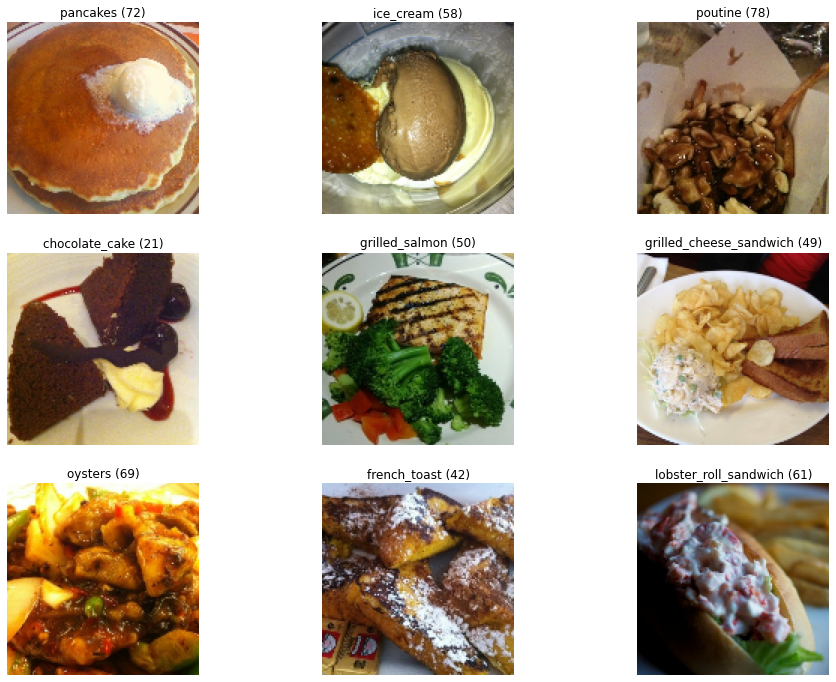

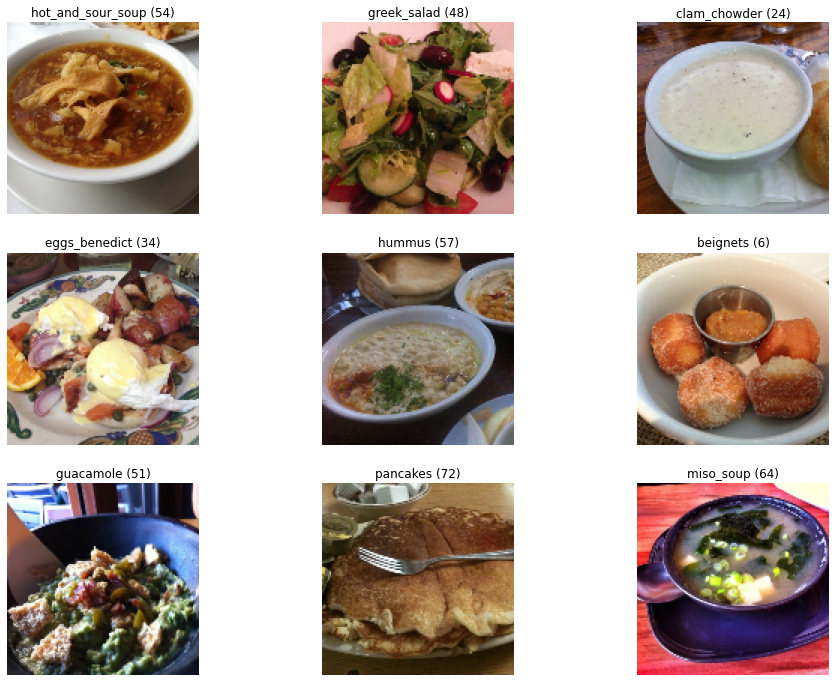

In [ ]:
def show_from_datagen(datagen, true_labels, n=9, rows=3):
  labels = datagen[0][1][:n]
  images = datagen[0][0][:n]
  plt.figure(figsize=(16,12))
  floor = rows
  ceil = math.ceil(n/rows)
  index = 0
  for i in range(floor):
    for j in range(ceil):
      if index >= n:
        break
      plt.subplot(floor, ceil, index+1)
      plt.imshow(images[index])
      plt.title(f"{true_labels[labels[index]]} ({labels[index]})")
      plt.axis("off")
      index += 1

show_from_datagen(datagen_train, labels)
show_from_datagen(datagen_test, labels)

In [ ]:
generator_factory = ImageDataGenerator(rescale=1/255,
                                       rotation_range=0.45,
                                       width_shift_range=0.45,
                                       height_shift_range=0.45,
                                       zoom_range= 0.5)
iterator = data['train'].take(10000)
datagen_train_augumented = generator_factory.flow(np.array([smart_resize(ele['image'], (128,128)) for ele in iterator.as_numpy_iterator()]),
                                       y=[ele['label'] for ele in iterator.as_numpy_iterator()],
                                       batch_size=32)

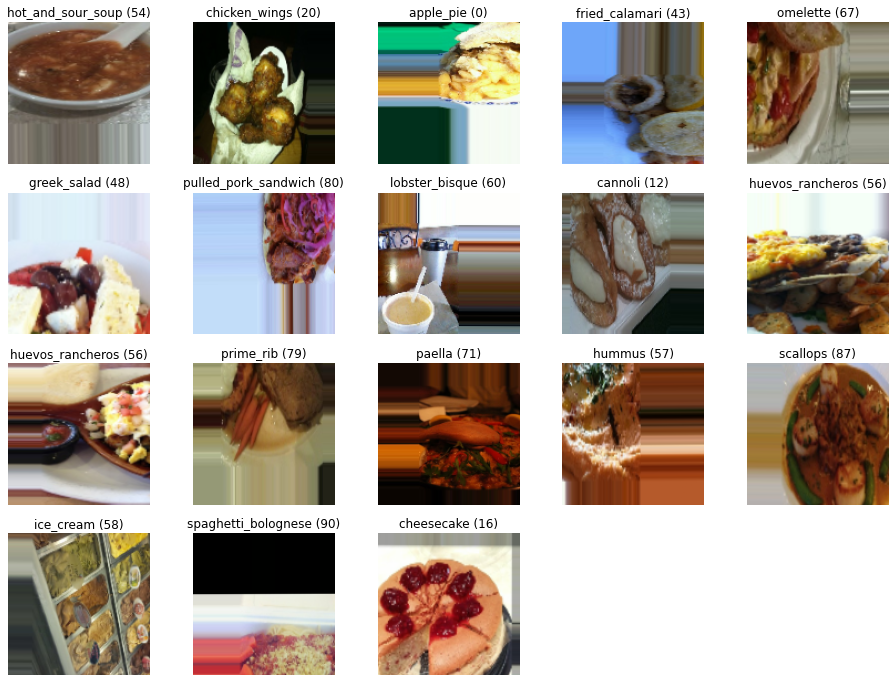

In [ ]:
show_from_datagen(datagen_train_augumented, labels, n=18, rows=4)

### Baseline

#### Using tensorboard callback

In [93]:
def build_tensorboard_callback(experiment):
  import datetime
  pathname = f".experiments/{experiment}/{datetime.datetime.now().strftime('%d%m%Y-%H%M%S')}"
  callback = tf.keras.callbacks.TensorBoard(log_dir=pathname)
  print(f"Saving tensorboard logfiles to {pathname}")
  return callback

In [ ]:
build_tensorboard_callback("model_1")

Saving tensorboard logfiles to .experiments/model_1/13062022-190325


In [ ]:
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(10,3, input_shape=(128,128,3), activation="relu"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(10,3, activation="relu"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(10,3, activation="relu"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(len(labels), activation="softmax")
])

model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 10)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 10)        910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 10)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 10)        910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 10)       0

In [ ]:
len(datagen_train),len(datagen_test)

(313, 157)

In [ ]:
history_1 = model_1.fit(datagen_train,
            epochs=5,
            steps_per_epoch=len(datagen_train),
            validation_data=datagen_test,
            validation_steps=len(datagen_test),
            callbacks=[build_tensorboard_callback("model_1")])

Saving tensorboard logfiles to .experiments/model_1/13062022-190325
Epoch 1/5
313/313 [==============================] - 16s 15ms/step - loss: 4.5497 - accuracy: 0.0212 - val_loss: 4.4222 - val_accuracy: 0.0376
Epoch 2/5
313/313 [==============================] - 5s 14ms/step - loss: 4.2437 - accuracy: 0.0700 - val_loss: 4.2835 - val_accuracy: 0.0714
Epoch 3/5
313/313 [==============================] - 4s 14ms/step - loss: 3.7865 - accuracy: 0.1384 - val_loss: 4.4303 - val_accuracy: 0.0644
Epoch 4/5
313/313 [==============================] - 4s 14ms/step - loss: 3.1995 - accuracy: 0.2543 - val_loss: 4.6012 - val_accuracy: 0.0660
Epoch 5/5
313/313 [==============================] - 5s 16ms/step - loss: 2.4739 - accuracy: 0.4023 - val_loss: 5.3125 - val_accuracy: 0.0650


#### Plotting the model

In [105]:
def plot_model(history):
  plt.figure(figsize=(8,4))
  index=1
  for metric in ["loss", "accuracy"]:
    plt.subplot(1,2,index)
    index+=1
    epochs = range(len(history.history[f"{metric}"]))
    plt.plot(epochs,history.history[f"{metric}"], label=f"{metric}")
    plt.plot(epochs,history.history[f"val_{metric}"], label=f"val_{metric}")
    plt.title(f"{metric}")
    plt.legend()

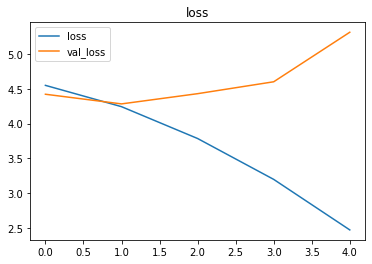

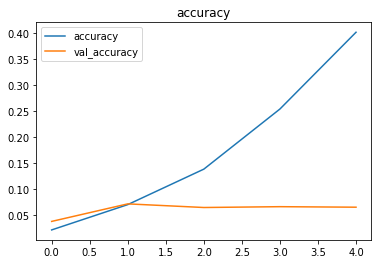

In [ ]:
plot_model(history_1)

In [ ]:
model_2 = tf.keras.models.clone_model(model_1)
model_2.compile(loss="sparse_categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 10)      280       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 10)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 10)        910       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 10)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 10)        910       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 10)      

In [ ]:
history_2 = model_2.fit(datagen_train_augumented,
                        epochs=5,
                        steps_per_epoch=len(datagen_train_augumented),
                        validation_data=datagen_test,
                        validation_steps=len(datagen_test),
                        callbacks=[build_tensorboard_callback("model_2")])

Saving tensorboard logfiles to .experiments/model_2/09062022-141024
Epoch 1/5
313/313 [==============================] - 41s 127ms/step - loss: 4.5933 - accuracy: 0.0162 - val_loss: 4.5420 - val_accuracy: 0.0178
Epoch 2/5
313/313 [==============================] - 40s 128ms/step - loss: 4.5287 - accuracy: 0.0241 - val_loss: 4.4181 - val_accuracy: 0.0448
Epoch 3/5
313/313 [==============================] - 39s 124ms/step - loss: 4.4565 - accuracy: 0.0345 - val_loss: 4.4212 - val_accuracy: 0.0480
Epoch 4/5
313/313 [==============================] - 39s 124ms/step - loss: 4.4213 - accuracy: 0.0370 - val_loss: 4.2894 - val_accuracy: 0.0586
Epoch 5/5
313/313 [==============================] - 39s 123ms/step - loss: 4.3974 - accuracy: 0.0406 - val_loss: 4.4107 - val_accuracy: 0.0444


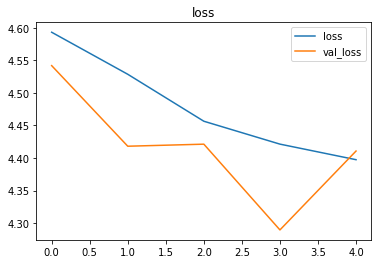

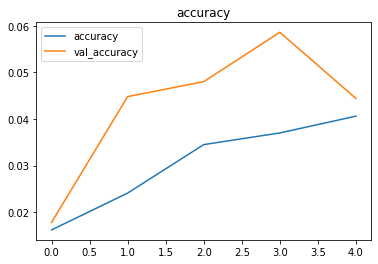

In [ ]:
plot_model(history_2)

Our `model_1` was overfitting, and was not capable of generalize the patterns.

Our `model_2` which was trained in augmented data shows a more promissing learning experience.

So, for now, let's define our baseline as `model_2`

### Trying to improve our learning in baseline

Let's first use more neurons. 

In [ ]:
def build_model(kernels, kernels_sizes, input_shape=(128,128,3)):
  model = tf.keras.Sequential()
  if(len(kernels) != len(kernels_sizes)):
    raise Exception("Should define a kernel size for each kernel")
  if(len(kernels) <= 0):
    raise Exception("Should have at least a kernel defined")
  model.add(tf.keras.layers.Input(input_shape))
  for i in range(len(kernels)):
    model.add(tf.keras.layers.Conv2D(kernels[i], kernels_sizes[i], activation="relu"))
    model.add(tf.keras.layers.Conv2D(kernels[i], kernels_sizes[i], activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(len(labels), activation="softmax"))

  print(model.summary())

  model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
  return model

In [ ]:
model_3 = build_model([32,32,32],[3,3,3])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 conv2d_10 (Conv2D)          (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 conv2d_12 (Conv2D)          (None, 58, 58, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 29, 29, 32)       0         
 g2D)                                                 

In [ ]:
history_3 = model_3.fit(datagen_train_augumented,
                        epochs=5,
                        steps_per_epoch=len(datagen_train_augumented),
                        validation_data=datagen_test,
                        validation_steps=len(datagen_test),
                        callbacks=[build_tensorboard_callback("model_3")])

Saving tensorboard logfiles to .experiments/model_3/09062022-141403
Epoch 1/5
313/313 [==============================] - 46s 141ms/step - loss: 4.6159 - accuracy: 0.0117 - val_loss: 4.6152 - val_accuracy: 0.0108
Epoch 2/5
313/313 [==============================] - 43s 137ms/step - loss: 4.6146 - accuracy: 0.0129 - val_loss: 4.6153 - val_accuracy: 0.0108
Epoch 3/5
313/313 [==============================] - 48s 152ms/step - loss: 4.6139 - accuracy: 0.0129 - val_loss: 4.6156 - val_accuracy: 0.0108
Epoch 4/5
313/313 [==============================] - 43s 137ms/step - loss: 4.6135 - accuracy: 0.0129 - val_loss: 4.6159 - val_accuracy: 0.0108
Epoch 5/5
313/313 [==============================] - 43s 139ms/step - loss: 4.6132 - accuracy: 0.0129 - val_loss: 4.6161 - val_accuracy: 0.0108


Our model is no better than random guessing.

Lets simplify it. 

In [ ]:
def build_model(kernels, kernels_sizes, input_shape=(128,128,3)):
  model = tf.keras.Sequential()
  if(len(kernels) != len(kernels_sizes)):
    raise Exception("Should define a kernel size for each kernel")
  if(len(kernels) <= 0):
    raise Exception("Should have at least a kernel defined")
  model.add(tf.keras.layers.Input(input_shape))
  for i in range(len(kernels)):
    model.add(tf.keras.layers.Conv2D(kernels[i], kernels_sizes[i], activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(len(labels), activation="softmax"))

  print(model.summary())

  model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
  return model

Now we have the same thing than our baseline. Lets rebuild it:

In [ ]:
model_4 = build_model([10,10,10],[3,3,3])
history_4 = model_4.fit(datagen_train_augumented,
                        epochs=5,
                        steps_per_epoch=len(datagen_train_augumented),
                        validation_data=datagen_test,
                        validation_steps=len(datagen_test),
                        callbacks=[build_tensorboard_callback("model_4")])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 10)      280       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 63, 63, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 10)        910       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 30, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 10)        910       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 10)      

In [ ]:
model_5 = build_model([10,10,10],[16,16,16])
history_5 = model_5.fit(datagen_train_augumented,
                        epochs=5,
                        steps_per_epoch=len(datagen_train_augumented),
                        validation_data=datagen_test,
                        validation_steps=len(datagen_test))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 113, 113, 10)      7690      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 10)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 41, 41, 10)        25610     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 20, 20, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 5, 5, 10)          25610     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 2, 2, 10)        

Increasing the number of kernels didnt appear to be promissing. Even change the size of each kernel did not work.Actualy the kernel with size 32 is the same as guessing.

Maybe we tried a kernel too big. Let's try a smaller kernel.

In [ ]:
model_6 = build_model([10,10,10],[8,8,8])
history_6 = model_6.fit(datagen_train_augumented,
                        epochs=5,
                        steps_per_epoch=len(datagen_train_augumented),
                        validation_data=datagen_test,
                        validation_steps=len(datagen_test))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 121, 121, 10)      1930      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 60, 60, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 53, 53, 10)        6410      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 26, 26, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 19, 19, 10)        6410      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 9, 9, 10)        

Again our model performs as good as guessing.

We should now try to increase the number of layers.

In [ ]:
model_7 = build_model([10,10,10,10],[3,3,3,3])
history_7 = model_7.fit(datagen_train_augumented,
                        epochs=5,
                        steps_per_epoch=len(datagen_train_augumented),
                        validation_data=datagen_test,
                        validation_steps=len(datagen_test))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 126, 126, 10)      280       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 63, 63, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 61, 61, 10)        910       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 30, 30, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 10)        910       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 10)      

Now we can see our model learning a little slower than our baseline. 

And if we use a crescent pattern of kernels. Searching for more details in advanced layers.

In [ ]:
model_8 = build_model([8,16,32],[3,3,3])
history_8 = model_8.fit(datagen_train_augumented,
                        epochs=5,
                        steps_per_epoch=len(datagen_train_augumented),
                        validation_data=datagen_test,
                        validation_steps=len(datagen_test))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 63, 63, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 30, 30, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 14, 14, 32)      

It seems to be learning faster than our baseline too. 

Lets mix both strategies

In [ ]:
model_9 = build_model([8,16,32,64],[3,3,3,3])
history_9 = model_9.fit(datagen_train_augumented,
                        epochs=5,
                        steps_per_epoch=len(datagen_train_augumented),
                        validation_data=datagen_test,
                        validation_steps=len(datagen_test))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 63, 63, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 30, 30, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 14, 14, 32)      

#### Lets plot everthing. 

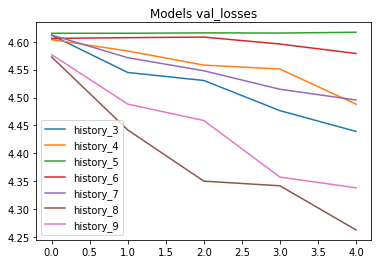

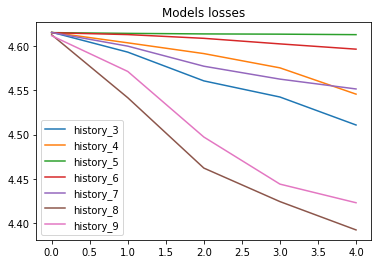

In [ ]:
def plot_models(histories, metric="loss", start_index=0):
  plt.figure()
  for history in histories:
    epochs = range(len(history.history[metric]))
    plt.plot(epochs, history.history[metric], label=f"history_{start_index}")
    start_index+=1
  plt.title(f"Models {metric}es")
  plt.legend()

histories = [history_3,history_4,history_5,history_6,history_7,history_8,history_9]
plot_models(histories, start_index=3, metric="val_loss")
plot_models(histories, start_index=3, metric="loss")

### Testing lerning rate

0.1
0.0316227766016838
0.010000000000000002
0.0031622776601683794
0.001
0.00031622776601683794
0.0001
3.1622776601683795e-05
1e-05
3.1622776601683796e-06


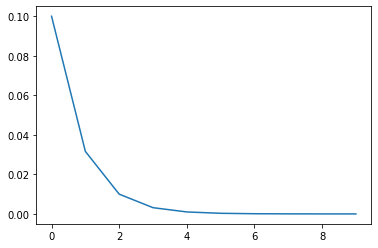

In [ ]:
x = []
for i in range(0,10):
  print(10e-2 * 10**(-i/2))
  x.append(10e-2 * 10**(-i/2))
plt.plot(range(10), x)

In [ ]:
model_10 = tf.keras.models.clone_model(model_4)

model_10.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics= ["accuracy"]
)

callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 10e-2 * 10**(-epoch/2))

history_10 = model_10.fit(datagen_train_augumented,
                          epochs=10,
                          steps_per_epoch=len(datagen_train_augumented),
                          validation_data=datagen_test,
                          validation_steps=len(datagen_test),
                          callbacks=[callback])

Epoch 1/10
79/79 [==============================] - 36s 448ms/step - loss: 13.7683 - accuracy: 0.0096 - val_loss: 4.6420 - val_accuracy: 0.0074 - lr: 0.1000
Epoch 2/10
79/79 [==============================] - 35s 447ms/step - loss: 4.6272 - accuracy: 0.0091 - val_loss: 4.6237 - val_accuracy: 0.0118 - lr: 0.0316
Epoch 3/10
79/79 [==============================] - 35s 446ms/step - loss: 4.6185 - accuracy: 0.0115 - val_loss: 4.6229 - val_accuracy: 0.0108 - lr: 0.0100
Epoch 4/10
79/79 [==============================] - 35s 446ms/step - loss: 4.6158 - accuracy: 0.0129 - val_loss: 4.6227 - val_accuracy: 0.0108 - lr: 0.0032
Epoch 5/10
79/79 [==============================] - 36s 459ms/step - loss: 4.6149 - accuracy: 0.0129 - val_loss: 4.6227 - val_accuracy: 0.0108 - lr: 0.0010
Epoch 6/10
79/79 [==============================] - 35s 446ms/step - loss: 4.6146 - accuracy: 0.0129 - val_loss: 4.6226 - val_accuracy: 0.0108 - lr: 3.1623e-04
Epoch 7/10
79/79 [==============================] - 35s 449

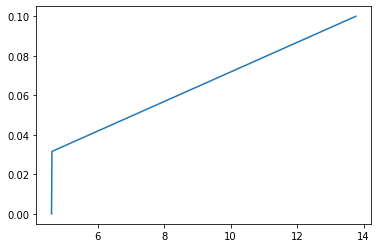

In [ ]:
plt.plot(history_10.history["loss"], history_10.history["lr"])

### Using transfer learning with TensorflowHub

Here we'll be using two types of transfer learning. 

> **The classic transfer-lerning**, where we take a classification model and just add a top layer which translate to our classes. 

> **The feature extraction transfer-learning** where we remove the top layer from the model, and change it to our top layer. 

Here we'll use two models for that. 

> efficient_net_b0, represented by `model_11`(classic transfer learning) and `model_12`(feature_extraction)

> resnet_50, represented by `model_13`(classic transfer learning) and `model_14`(feature_extraction)

In [ ]:
efficient_net_b0 = tf.keras.models.Sequential([
      tfhub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/classification/1", trainable=False)
])
efficient_net_b0.build([None, 128, 128, 3])

In [ ]:
efficient_net_b0.input_shape

(None, 128, 128, 3)

In [ ]:
model_11 = tf.keras.models.Sequential([
      efficient_net_b0,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(len(labels), activation="softmax")
])

model_11.compile(optimizer="adam",
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

model_11.fit(
    datagen_train_augumented,
    epochs=5,
    steps_per_epoch=len(datagen_train_augumented),
    validation_data=datagen_test,
    validation_steps=len(datagen_test),
    callbacks=[build_tensorboard_callback("model_11")]
)

Saving tensorboard logfiles to .experiments/model_11/13062022-190412
Epoch 1/5
313/313 [==============================] - 57s 152ms/step - loss: 4.5510 - accuracy: 0.0585 - val_loss: 4.2924 - val_accuracy: 0.1276
Epoch 2/5
313/313 [==============================] - 45s 142ms/step - loss: 4.2712 - accuracy: 0.0935 - val_loss: 3.8075 - val_accuracy: 0.1478
Epoch 3/5
313/313 [==============================] - 44s 142ms/step - loss: 4.0410 - accuracy: 0.1137 - val_loss: 3.6004 - val_accuracy: 0.1664
Epoch 4/5
313/313 [==============================] - 44s 142ms/step - loss: 3.9125 - accuracy: 0.1295 - val_loss: 3.4944 - val_accuracy: 0.1866
Epoch 5/5
313/313 [==============================] - 45s 144ms/step - loss: 3.8459 - accuracy: 0.1398 - val_loss: 3.4299 - val_accuracy: 0.1936


In [ ]:
efficient_net_fv = tf.keras.models.Sequential([
      tfhub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2", trainable=False)
])
efficient_net_fv.build([None, 128, 128, 3])

model_12 = tf.keras.models.Sequential([
      efficient_net_fv,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(len(labels), activation="softmax")
])

model_12.compile(optimizer="adam",
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

model_12.fit(
    datagen_train_augumented,
    epochs=5,
    steps_per_epoch=len(datagen_train_augumented),
    validation_data=datagen_test,
    validation_steps=len(datagen_test),
    callbacks=[build_tensorboard_callback("model_12")]
)

Saving tensorboard logfiles to .experiments/model_12/13062022-191034
Epoch 1/5
313/313 [==============================] - 58s 160ms/step - loss: 3.9774 - accuracy: 0.1211 - val_loss: 3.0022 - val_accuracy: 0.2782
Epoch 2/5
313/313 [==============================] - 45s 142ms/step - loss: 3.2831 - accuracy: 0.2319 - val_loss: 2.6728 - val_accuracy: 0.3458
Epoch 3/5
313/313 [==============================] - 47s 150ms/step - loss: 3.0465 - accuracy: 0.2760 - val_loss: 2.5173 - val_accuracy: 0.3636
Epoch 4/5
313/313 [==============================] - 44s 142ms/step - loss: 2.9148 - accuracy: 0.3048 - val_loss: 2.4535 - val_accuracy: 0.3858
Epoch 5/5
313/313 [==============================] - 44s 142ms/step - loss: 2.8138 - accuracy: 0.3180 - val_loss: 2.3601 - val_accuracy: 0.4064


In [ ]:
resnet_v1_50 = tf.keras.models.Sequential([
      tfhub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/classification/5", trainable=False)
])
resnet_v1_50.build([None, 128, 128, 3])

In [ ]:
model_13 = tf.keras.models.Sequential([
      resnet_v1_50,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(len(labels), activation="softmax")
])

model_13.compile(optimizer="adam",
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

model_13.fit(
    datagen_train_augumented,
    epochs=5,
    steps_per_epoch=len(datagen_train_augumented),
    validation_data=datagen_test,
    validation_steps=len(datagen_test),
    callbacks=[build_tensorboard_callback("model_13"), tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)]
)

Saving tensorboard logfiles to .experiments/model_13/13062022-191433
Epoch 1/5
313/313 [==============================] - 50s 155ms/step - loss: 4.6106 - accuracy: 0.0667 - val_loss: 3.7801 - val_accuracy: 0.1520
Epoch 2/5
313/313 [==============================] - 48s 153ms/step - loss: 3.9677 - accuracy: 0.1339 - val_loss: 3.3375 - val_accuracy: 0.2312
Epoch 3/5
313/313 [==============================] - 49s 155ms/step - loss: 3.7369 - accuracy: 0.1626 - val_loss: 3.1823 - val_accuracy: 0.2514
Epoch 4/5
313/313 [==============================] - 48s 155ms/step - loss: 3.5731 - accuracy: 0.1878 - val_loss: 3.1172 - val_accuracy: 0.2622
Epoch 5/5
313/313 [==============================] - 48s 152ms/step - loss: 3.5173 - accuracy: 0.1962 - val_loss: 3.0747 - val_accuracy: 0.2754


In [ ]:
resnet_fv = tf.keras.models.Sequential([
      tfhub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5", trainable=False)
])
resnet_fv.build([None, 128, 128, 3])

model_14 = tf.keras.models.Sequential([
      resnet_fv,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(len(labels), activation="softmax")
])

model_14.compile(optimizer="adam",
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

model_14.fit(
    datagen_train_augumented,
    epochs=5,
    steps_per_epoch=len(datagen_train_augumented),
    validation_data=datagen_test,
    validation_steps=len(datagen_test),
    callbacks=[build_tensorboard_callback("model_14")]
)

Saving tensorboard logfiles to .experiments/model_14/13062022-191840
Epoch 1/5
313/313 [==============================] - 51s 153ms/step - loss: 4.3137 - accuracy: 0.0780 - val_loss: 3.4607 - val_accuracy: 0.1862
Epoch 2/5
313/313 [==============================] - 48s 152ms/step - loss: 3.7325 - accuracy: 0.1538 - val_loss: 3.0994 - val_accuracy: 0.2664
Epoch 3/5
313/313 [==============================] - 49s 156ms/step - loss: 3.5124 - accuracy: 0.1899 - val_loss: 2.9298 - val_accuracy: 0.2858
Epoch 4/5
313/313 [==============================] - 48s 153ms/step - loss: 3.3847 - accuracy: 0.2160 - val_loss: 2.8909 - val_accuracy: 0.2972
Epoch 5/5
313/313 [==============================] - 47s 152ms/step - loss: 3.3204 - accuracy: 0.2245 - val_loss: 2.7922 - val_accuracy: 0.3294


#### Feature extraction works better than classic transfer learning. 

In [ ]:
model_12.fit(
    datagen_train_augumented,
    epochs=200,
    steps_per_epoch=len(datagen_train_augumented),
    validation_data=datagen_test,
    validation_steps=len(datagen_test),
    callbacks=[build_tensorboard_callback("model_12"), tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)]
)

Saving tensorboard logfiles to .experiments/model_12/13062022-192551
Epoch 1/200
313/313 [==============================] - 45s 143ms/step - loss: 2.7090 - accuracy: 0.3392 - val_loss: 2.3625 - val_accuracy: 0.3998
Epoch 2/200
313/313 [==============================] - 44s 140ms/step - loss: 2.6417 - accuracy: 0.3504 - val_loss: 2.3750 - val_accuracy: 0.4042
Epoch 3/200
313/313 [==============================] - 44s 141ms/step - loss: 2.5950 - accuracy: 0.3587 - val_loss: 2.3221 - val_accuracy: 0.4166
Epoch 4/200
313/313 [==============================] - 44s 140ms/step - loss: 2.5263 - accuracy: 0.3713 - val_loss: 2.3266 - val_accuracy: 0.4182
Epoch 5/200
313/313 [==============================] - 45s 145ms/step - loss: 2.4719 - accuracy: 0.3883 - val_loss: 2.3107 - val_accuracy: 0.4236
Epoch 6/200
313/313 [==============================] - 44s 141ms/step - loss: 2.4483 - accuracy: 0.3916 - val_loss: 2.3615 - val_accuracy: 0.4166
Epoch 7/200
313/313 [==============================] - 

#### Some prediction case

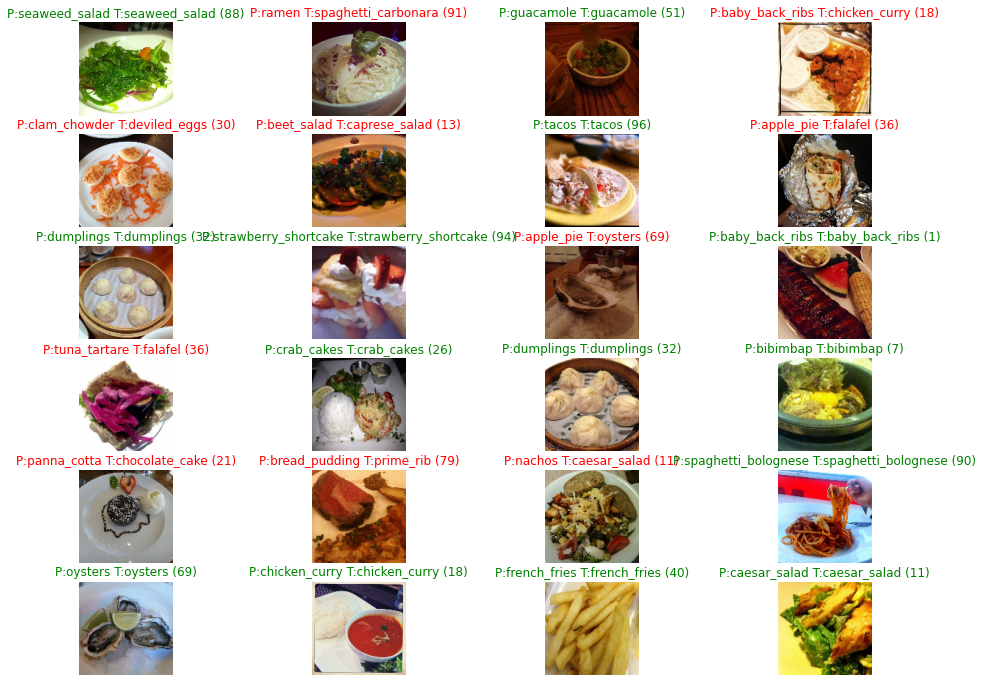

In [ ]:
def show_prediction_from_datagen(datagen, model, true_labels, n=9, rows=3):
  datagenaux = datagen.next()
  labels = datagenaux[1][:n]
  images = datagenaux[0][:n]
  plt.figure(figsize=(16,12))
  floor = rows
  ceil = math.ceil(n/rows)
  index = 0
  for i in range(floor):
    for j in range(ceil):
      if index >= n:
        break
      plt.subplot(floor, ceil, index+1)
      plt.imshow(images[index])
      pred = model.predict(tf.reshape(images[index],(1,128,128,3)))
      pred_index = tf.argmax(pred, axis=-1)[0]
      pred_label = true_labels[pred_index]
      title = plt.title(f"P:{pred_label} T:{true_labels[labels[index]]} ({labels[index]})")
      plt.setp(title, color='r' if pred_index != labels[index] else 'g')
      plt.axis("off")
      index += 1

show_prediction_from_datagen(datagen_train, model_12, labels, n=6*4, rows=6)

In [ ]:
model_12.save("model_12.h5")

In [ ]:
from google.colab import files

files.download("model_12.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Using fine-tunning

> **fine-tunning** is a type of transfer learning where we unfreeze some of the top layers in the **feature extraction** model.

In [58]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.layers[:5]

16719872/16705208 [==============================] - 0s 0us/step


In [50]:
def takedataset_to_tensor(data, n, img_size=(128,128)):
  iterator = data.take(n)
  x_data = np.array([smart_resize(ele['image'], img_size) for ele in iterator.as_numpy_iterator()])
  y_data = np.array([ele['label'] for ele in iterator.as_numpy_iterator()])
  return x_data, y_data

takedataset_to_tensor(data['train'], 1)

(array([[[[226.  , 254.75, 251.75],
          [201.75, 254.75, 250.5 ],
          [171.  , 253.5 , 253.75],
          ...,
          [206.25, 187.75, 158.  ],
          [177.75, 165.  , 150.75],
          [132.5 , 128.75, 129.25]],
 
         [[200.5 , 253.  , 249.25],
          [181.25, 251.25, 252.5 ],
          [147.5 , 238.25, 248.5 ],
          ...,
          [221.5 , 205.25, 163.5 ],
          [224.25, 208.25, 168.5 ],
          [217.25, 207.5 , 175.  ]],
 
         [[171.5 , 249.  , 244.  ],
          [164.25, 251.5 , 252.75],
          [143.25, 238.  , 252.25],
          ...,
          [221.75, 206.25, 173.5 ],
          [228.  , 210.25, 168.  ],
          [226.5 , 212.  , 173.5 ]],
 
         ...,
 
         [[ 81.25,  99.25, 130.25],
          [ 57.25,  75.75, 103.25],
          [ 62.5 ,  76.5 , 101.  ],
          ...,
          [  3.5 ,  11.5 ,  23.5 ],
          [  3.  ,  12.  ,  25.75],
          [  4.  ,  14.  ,  25.5 ]],
 
         [[ 51.75,  84.25, 123.25],
          [1

Text(0.5, 1.0, 'huevos_rancheros')

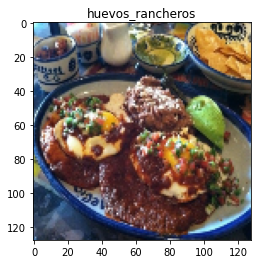

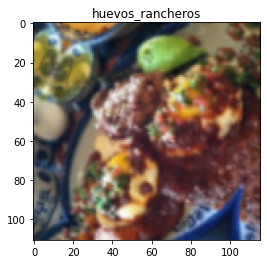

In [62]:
### We should not add rescaling because Efficient net already use reascaling to range [-1,1]. 
data_augmentation_layer = tf.keras.Sequential([
      preprocessing.RandomFlip("horizontal"),
      preprocessing.RandomHeight(.2),
      preprocessing.RandomWidth(.2),
      preprocessing.RandomZoom(.3),
      preprocessing.RandomRotation(.45)
])

tensors = takedataset_to_tensor(data['train'], 1)
plt.figure()
plt.imshow(tensors[0][0]/255.)
plt.title(labels[tensors[1][0]])

sample = data_augmentation_layer(tensors[0]/255., training=True)

plt.figure()
plt.imshow(sample[0])
plt.title(labels[tensors[1][0]])

#### Small subset of data. 

Here on, we will experiment with our models with about 10 images per class.

Also, here I wont use datagen, because I learned that the tf ImageGenerator works on CPU. So create layers to data augumentation is better than use the imageGenerator because the model works on GPU.

In [85]:
x, y = takedataset_to_tensor(data['train'],1100)
x_test, y_test = takedataset_to_tensor(data['validation'],1100)

In [64]:
x.shape, y.shape, x_test.shape, y_test.shape

((1100, 128, 128, 3), (1100,), (1100, 128, 128, 3), (1100,))

#### get_base_efficientnet

This function will help us to get a model 100% like feature extraction or get a model with **fine tunning**

In [87]:
def get_base_efficientnet(enable_layers_greater_than = None):
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
  base_model.treinable=False
  index = 0
  for layer in base_model.layers:
    index+=1
    layer.trainable=False
    if enable_layers_greater_than != None and index > enable_layers_greater_than:
      layer.trainable=True
  return base_model

#### New baseline - Model with feature extraction 

This model is very similar to `model_12`, it uses the **feature extraction** approach, but this time we dont use a extra layer before the output layer. 

Also, instead of use Flatten, here we'll be using GlobalAvaragePooling. 

As we can see, it's **not** the same thing than `model_12` but it uses the same approach as some of its layers. 

In [95]:
base_model = get_base_efficientnet()

inputs = tf.keras.layers.Input(shape=(128,128,3))
outputs = data_augmentation_layer(inputs, training=True)
outputs = base_model(outputs, training=False)
outputs = tf.keras.layers.GlobalAveragePooling2D()(outputs)
outputs = tf.keras.layers.Dense(len(labels), activation="softmax")(outputs)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 sequential_20 (Sequential)  (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_15  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_17 (Dense)            (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
__________________________________________

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x=x,y=y,batch_size=32,epochs=5, validation_data=(x_test,y_test), validation_batch_size=32,
                    callbacks=[build_tensorboard_callback("baseline-feature-extraction[10PerClass]")])

#### Plotting the baseline

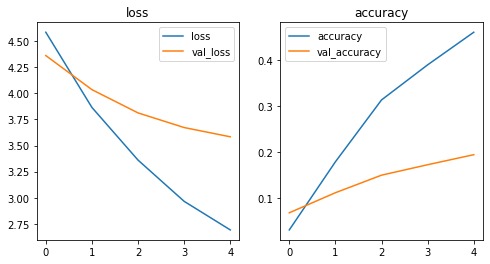

In [106]:
plot_model(history)

### Using Tensorboard

In [ ]:
%load_ext tensorboard
#%tensorboard --logdir .experiments
!tensorboard dev upload \
  --logdir .experiments \
  --name "Food101" \
  --description "Transfer lerning - feature extraction" \
  --one_shot

!pip install wandb

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/aCbQfGJ0Rx2rTGdV99Q6kg/

[2022-06-13T20:38:29] Started scanning logdir.
[2022-06-13T20:38:35] Total uploaded: 246 scalars, 0 tensors, 7 binary objects (14.1 MB)
[2022-06-13T20:38:35] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/aCbQfGJ0Rx2rTGdV99Q6kg/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.9 MB/s 
     |████████████████████████████████| 145 kB 62.3 MB/s 
     |████████████████████████████████| 181 kB 20.0 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=e2c492e0f72918db87de99f23d717bf1df04fd90315dc2a4ed3589e496bcb161
  Stored in directory: /root/.cache/pip/whee

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.tensorboard.unpatch()

In [ ]:
import wandb
# Just start a W&B run, passing `sync_tensorboard=True)`, to plot your Tensorboard files
wandb.tensorboard.unpatch()
wandb.tensorboard.patch(root_logdir="./logs/")
wandb.init(project="Testando")

# If running in a notebook, finish the wandb run to upload the tensorboard logs to W&B
wandb.finish()

In [ ]:
wandb.run